# SageMaker Custom Image

- User can configure training env and build the container image and save in registry
- Must build according to the guide so that sagemaker can run
- With image registry uri, users can share it with others

## Example Code

We'll trian the same CNN model with script mode demo.

#### Training is done in the following order:
1. Build development environment
2. Prepare input data
3. Modify training code (input data, output model)
4. Build docker image
5. Run training job
6. Deploy saved models

## 1. Build development environment

#### Set up the Notebook environment
Training script for demo is based on `Pytorch` framework.
- instance spec: ml.g4dn.xlarge (4vCPU + 16GB + 1GPU)
- kernel image: PyTorch 1.6 Python 3.6 GPU Optimized

## 2. Prepare input data

#### Download the CIFAR-10 dataset

I have previously downloaded the data in the `./data` directory.  
I prepared `get_cifar10.py` file that convert downloaded dataset to pytorch framework's `DataLoader` type.  

In [1]:
from get_cifar10 import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


#### Save the dataset in S3

To transfer our dataset to training job, upload our datasets to object storage.

In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

train_s3_path = sagemaker_session.upload_data(path="data", 
                                       bucket=sagemaker_session.default_bucket(), 
                                       key_prefix="data/cifar10")

print(train_s3_path)

s3://sagemaker-ap-northeast-2-834160605896/data/cifar10


## 3. Modify code

#### Prepared pre-developed code
```
source
├── my_cnn.py    # CNN Model network code
└── train.py     # training and evaluation code
```

For using this code in SageMaker, I created `train_sagemaker.py` file.

#### What to modify

- Set <u>input data path</u> and <u>model saving path</u> to the path guided by sagemaker.
- Add model load function to deploy saved model.

## 4. Build docker image

Using the docker image, users can configure the custom training environment by installing various packages rather than the framework provided by sagemaker.

#### Prepare Dockerfile
I use this Dockerfile for this demo.

```Dockerfile
FROM nexus-registry.sel-d4.sr-cloud.com:12000/ubuntu16.04-python3.7-cuda10.1-cudnn7.6-pytorch1.0.1:latest
RUN pip3 install sagemaker-training
RUN pip3 install Pillow==6.1
COPY my_cnn.py /opt/ml/code/my_cnn.py
COPY train_sagemaker.py /opt/ml/code/train.py
ENV SAGEMAKER_PROGRAM train.py
```

#### Build docker image

```
sudo docker build -t mlp/mlp-base-image:pytorch-2 .
```

#### Register to docker registry

```
sudo docker push 834160605896.dkr.ecr.ap-northeast-2.amazonaws.com/mlp/mlp-base-image:pytorch-2
```

## 5. Run training job

In [3]:
import sagemaker
from sagemaker.estimator import Estimator

custom_image_uri = '834160605896.dkr.ecr.ap-northeast-2.amazonaws.com/mlp/mlp-base-image:pytorch-2'
job_name = 'DEMO-built-in'
instance_type = 'ml.m4.xlarge'

estimator = Estimator(
    image_uri=custom_image_uri,
    role=sagemaker.get_execution_role(),
    base_job_name='customimage',
    instance_count=1,
    instance_type='ml.p2.xlarge'
)

# start training
estimator.fit(train_s3_path, logs=False)


2021-06-27 14:33:26 Starting - Starting the training job
2021-06-27 14:33:28 Starting - Launching requested ML instances............
2021-06-27 14:34:35 Starting - Preparing the instances for training............
2021-06-27 14:35:39 Downloading - Downloading input data.
2021-06-27 14:35:51 Training - Downloading the training image...........................................................
2021-06-27 14:40:52 Training - Training image download completed. Training in progress......................................................................................................................................................
2021-06-27 14:53:28 Uploading - Uploading generated training model
2021-06-27 14:53:30 Completed - Training job completed


## 6. Deploy saved models

In [10]:
estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

INFO:sagemaker:Creating model with name: DEMO-script-mode-2021-06-27-14-07-39-970
INFO:sagemaker:Creating endpoint with name DEMO-script-mode-2021-06-27-14-07-39-970


---------------------!

GroundTruth:   cat  car plane truck
Predicted:   cat  car plane truck


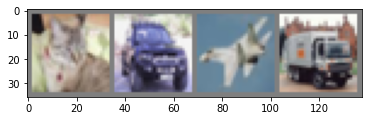

In [21]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))